# CHEMICAL SIMULATION WITH VQE

This notebook shows how to use VQE in Qiskit's Aqua to obtain the dissociation profile of a molecule. 

We start by defining the molecule ($H_2$ in this case) and the method we will use to transform the fermionic hamiltonian into a qubit hamiltonian.

In [1]:
from qiskit.chemistry.drivers import PySCFDriver, UnitsType, Molecule
from qiskit.chemistry.transformations import FermionicTransformation, FermionicQubitMappingType

molecule = Molecule(geometry=[['H', [0., 0., 0.]],
                              ['H', [0., 0., 0.735]]],
                     charge=0, multiplicity=1)
driver = PySCFDriver(molecule = molecule, unit=UnitsType.ANGSTROM, basis='sto3g')
transformation = FermionicTransformation(qubit_mapping=FermionicQubitMappingType.JORDAN_WIGNER)

Now, we create a VQE instance that will use the UCCSD ansatz to estimate the ground state.

In [2]:
from qiskit import Aer
from qiskit.aqua import QuantumInstance
from qiskit.chemistry.algorithms.ground_state_solvers.minimum_eigensolver_factories import VQEUCCSDFactory

vqe_solver = VQEUCCSDFactory(QuantumInstance(Aer.get_backend('statevector_simulator')))

We run it and display the information obtained about the electronic structure.

In [3]:
from qiskit.chemistry.algorithms.ground_state_solvers import GroundStateEigensolver

calc = GroundStateEigensolver(transformation, vqe_solver)
res = calc.solve(driver)

print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030144
  - computed part:      -1.857275030144
  - frozen energy part: 0.0
  - particle hole part: 0.0
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035695
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.38894864]
    - computed part:      [0.0  0.0  1.38894864]
    - frozen energy part: [0.0  0.0  0.0]
    - particle hole part: [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  0.00000006]  Total: 0.00000006
                 (debye): [0.0  0.0  0.00000015]  Total: 0.00000015
 


For comparison, we can do the same with an exact eigensolver. 

In [4]:
from qiskit.aqua.algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()

calc = GroundStateEigensolver(transformation, numpy_solver)
res = calc.solve(driver)
print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
  - frozen energy part: 0.0
  - particle hole part: 0.0
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
    - frozen energy part: [0.0  0.0  0.0]
    - particle hole part: [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.
                 (debye): [0.0  0.0  0.0]  Total: 0.
 


Now we use both the VQE and the exact solver to compute the molecule energy as a function of the distance between the atoms.

In [5]:
import numpy as np

distances = np.linspace(0.25, 3.0, 30)
exact_energies = []
vqe_energies = []
for dist in distances:
    molecule = Molecule(geometry=[['H', [0., 0., 0.]],
                              ['H', [0., 0., dist]]],
                     charge=0, multiplicity=1)
    driver = PySCFDriver(molecule = molecule, unit=UnitsType.ANGSTROM, basis='sto3g')
    # Exact solver
    calc = GroundStateEigensolver(transformation, numpy_solver)
    res = calc.solve(driver)
    exact_energies.append(res.total_energies)
    # VQE
    calc = GroundStateEigensolver(transformation, vqe_solver)
    res = calc.solve(driver)
    vqe_energies.append(res.total_energies)
    

We plot the results

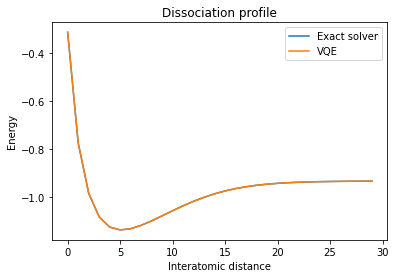

In [6]:
import matplotlib.pyplot as plt

plt.plot(exact_energies, label = 'Exact solver')
plt.plot(vqe_energies, label = 'VQE')
plt.title('Dissociation profile')
plt.xlabel('Interatomic distance')
plt.legend()
plt.ylabel('Energy');